# Explanations on Graph Neural Networks

## Initialization
---
Please confirm you selected kernel is PyTorch-1.8 and the selected specification is GPU.

In [1]:
import sys

print(sys.executable)

/home/thomas/anaconda3/envs/fact-ai/bin/python


In [2]:
# !wget https://modelarts-cnnorth1-market-dataset.obs.cn-north-1.myhuaweicloud.com/example-apps/explain_graphs/packages.zip
# !wget https://modelarts-cnnorth1-market-dataset.obs.cn-north-1.myhuaweicloud.com/example-apps/explain_graphs/ckpt.zip
# !wget https://obs-aigallery-zc.obs.cn-north-4.myhuaweicloud.com/dataset/gallery/requirements.txt
# !pip install -r requirements.txt
# !unzip -o packages.zip
# !unzip -o ckpt.zip

In [3]:
import sys
sys.path.append('./packages/gcn_interpretation/gnn-model-explainer')
sys.path.append('./packages/ldbExtraction')
from explain_graphs import *
import dnn_invariant.extract_rules as extract

In [4]:
# import dependencies
import torch
import numpy as np
import random

import networkx as nx
import matplotlib.pyplot as plt

In [5]:
# configure libraries
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# torch.use_deterministic_algorithms(True)

# configure GPU
gpu_id = 0
torch.cuda.set_device(gpu_id)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
device = 'cuda:0'

In [6]:
# get arguments
args = get_mutagenicity_args()
args.num_epochs = 10

# set constants
train = True

# Load model and dataset
---

In [7]:
# load ckpt containing model and dataset
ckpt = torch.load("./ckpt/Mutagenicity/Mutagenicity_base_h20_o20.pth.tar")
cg_dict = ckpt["cg"]

# extract model from ckpt
input_dim = cg_dict["feat"].shape[2]
num_classes = cg_dict["pred"].shape[2]

model = get_mutagenicity_model(input_dim, num_classes, device, args).cuda()
model.load_state_dict(ckpt["model_state"])

# extract dataset from ckpt
adj, feat, label, pred, num_nodes = get_dataset_from_ckpt(ckpt)

size = 3035
train_data = (adj[:size], feat[:size], label[:size], num_nodes[:size])
val_data = (adj[size - 100:], feat[size - 100:], label[size - 100:], num_nodes[size - 100:])

# get graphs to explain
graph_indices = []
preds = np.argmax(cg_dict['pred'][0,:,:], axis=1) 
for i, l in enumerate(preds):
    # explain predictions for class 0 (mutagenic) for Mutagenicity
    if l == 0:
        graph_indices.append(i)

## Extract Rules

In [8]:
# extract rules for each graph
rule_dict = extract.extract_rules('Mutagenicity', train_data, val_data, args, model.state_dict(), graph_indices=None, pool_size=50)

rule label:  0
rule: pos samples 1742
rule: neg samples 1258
Rules extracted:  {'boundary': [{'basis': array([ -0.7778877 ,   2.7435977 ,  17.096867  ,  -2.230471  ,
         7.4752607 ,   3.057279  ,  23.858824  ,  17.076761  ,
        20.68311   ,  -2.4843447 , -25.7729    ,  -0.6883296 ,
        10.373083  , -10.964664  ,  -2.3192563 ,  -1.9224882 ,
       -19.005634  , -21.42466   ,   3.007985  ,  -1.1455414 ,
        -0.13652897], dtype=float32), 'label': 1}], 'label': 0}
rule label:  1
rule: pos samples 1258
rule: neg samples 1742
Rules extracted:  {'boundary': [{'basis': array([  0.7778877 ,  -2.7435977 , -17.096867  ,   2.230471  ,
        -7.4752607 ,  -3.057279  , -23.858824  , -17.076761  ,
       -20.68311   ,   2.4843447 ,  25.7729    ,   0.6883296 ,
       -10.373083  ,  10.964664  ,   2.3192563 ,   1.9224882 ,
        19.005634  ,  21.42466   ,  -3.007985  ,   1.1455414 ,
         0.13652891], dtype=float32), 'label': 0}], 'label': 1}


## Load explainer model

In [9]:
explainer = ExplainModule(
    model = model, 
    num_nodes = adj.shape[1],
    emb_dims = model.embedding_dim * model.num_layers * 2, 
    device = device,
    args = args
)

# Load explainer model from file
state_dict = torch.load('./ckpt/Mutagenicity/RCExplainer/rcexplainer.pth.tar')

exp_state_dict = explainer.state_dict()
for name, param in state_dict.items():
    if name in exp_state_dict and not ("model" in name):
        exp_state_dict[name].copy_(param)
explainer.load_state_dict(state_dict)

<All keys matched successfully>

## Train explainer

In [10]:
# train
if train:
    explainer = train_explainer(explainer, model, rule_dict, adj, feat, label, pred, num_nodes, args, graph_indices)

./packages/gcn_interpretation/gnn-model-explainer/explain_graphs.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(sub_label, dtype=torch.long).cuda()
/home/thomas/anaconda3/envs/fact-ai/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	 Loss: 2063.329833984375
Epoch: 1 	 Loss: 2363.873046875
Epoch: 2 	 Loss: 2238.60546875
Epoch: 3 	 Loss: 1990.7418212890625
Epoch: 4 	 Loss: 2248.955322265625
Epoch: 5 	 Loss: 2156.1708984375
Epoch: 6 	 Loss: 1958.245849609375
Epoch: 7 	 Loss: 2148.54345703125
Epoch: 8 	 Loss: 2259.973388671875
Epoch: 9 	 Loss: 2086.25244140625
Sparsity, 0.0000,0.5103,0.7650,0.8244,0.8696,0.9233,0.9701,0.9999,1.0000,
Fidelity, -0.0626,0.3292,0.7398,0.7575,0.7331,0.5891,0.2665,0.0005,0.0000,



## Evaluate explainer 
### Performance evaluation

In [12]:
# explain and model
explanations = evaluate_explainer(explainer, model, rule_dict, adj, feat, label, pred, num_nodes, args, graph_indices)

Loss: 1922.1318359375
Sparsity, 0.0000,0.5239,0.7786,0.8409,0.8867,0.9399,0.9809,1.0000,1.0000,
Fidelity, -0.0626,0.3625,0.7184,0.7178,0.6750,0.4982,0.2047,0.0002,0.0000,



### Visualize explanation on single graph

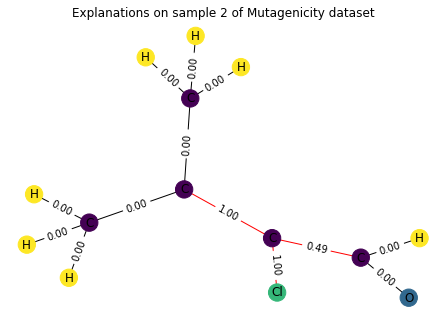

In [13]:
visualization_index = 2
feat_tmp = feat[visualization_index]
adj_tmp = adj[visualization_index]
explanation = explanations[visualization_index]

nz_idx, nz = np.nonzero(feat_tmp.numpy())
node_labels = {idx: nz[idx] for idx in nz_idx}

node_lut = {
    0: 'C',
    1: 'O',
    2: 'Cl', 
    3: 'H',
    4: 'N',
    5: 'F',
    6: 'Br', 
    7: 'S', 
    8: 'P', 
    9: 'I',
    10: 'Na', 
    11: 'K', 
    12: 'Li', 
    13: 'Ca'
}

node_colors = [node_labels[idx] for idx in nz_idx]

G = nx.Graph()

for idx in nz_idx:
    G.add_node(idx, atom=node_lut[node_labels[idx]], color=node_colors[idx])

edge_labels = {}

x, y = np.nonzero(adj_tmp.numpy())
for i in range(len(x)):
    edge_labels[(x[i], y[i])] = explanation[x[i], y[i]]

for a, b in edge_labels.keys():
    color = "r" if edge_labels[(a,b)] > 0.1 else "black"
    G.add_edge(a, b, color=color, wdith='1.0', weight="{:1.2f}".format(edge_labels[(a, b)]))

pos = nx.spring_layout(G, weight=1.0)
plt.figure()
node_labels = nx.get_node_attributes(G, "atom")

edges = G.edges()
edge_colors = [G[u][v]['color'] for u, v in edges]

nodes = G.nodes()
node_colors = nx.get_node_attributes(G, 'color')
node_colors = [node_colors[i] for i in node_colors.keys()] 
nx.draw(G, pos, labels=node_labels, node_color=node_colors, edge_color=edge_colors)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# nx.draw_networkx_edge_labels(G, pos)
plt.title("Explanations on sample " + str(visualization_index) + " of Mutagenicity dataset")
plt.show()
